# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [1]:
import sys
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os
import gc

GPU device not found
Found GPU at: 


In [2]:
gc.collect()

15

In [3]:
tf.keras.backend.set_floatx("float64")

In [4]:
dataset = "pets"
loader = dl.DataLoader(IMAGE_SIZE=128,dataset=dataset)
img_ds = loader.import_processed_img()
seg_ds = loader.import_processed_seg()

In [10]:
cardinality = img_ds.cardinality()
train_size = 7000
img_train = img_ds.take(train_size)
seg_train = seg_ds.take(train_size)
img_test = img_ds.skip(train_size)
seg_test = seg_ds.skip(train_size)

keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 64.0
Starting level 1


C:\Users\spurl\AppData\Local\Temp\__autograph_generated_filet9nmd4vv.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt((ag__.ld(self).data_format is 'channels_first'), if_body, else_body, get_state, set_state, ('pad',), 1)
C:\Users\spurl\AppData\Local\Temp\__autograph_generated_filet9nmd4vv.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt((ag__.ld(self).data_format is 'channels_last'), if_body_1, else_body_1, get_state_1, set_state_1, ('pad',), 1)


Completing 32.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 16.0
saving to: models/pets_img
out.shape (1, 16, 16, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576

array([[[0.81798166, 0.73197001, 0.7411564 ],
        [0.75214791, 0.65082604, 0.63651937],
        [0.74894232, 0.63819271, 0.62207341],
        ...,
        [0.92448515, 0.92448515, 0.92448515],
        [0.92936224, 0.92936224, 0.92936224],
        [0.92763484, 0.92763484, 0.92763484]],

       [[0.81168455, 0.71747142, 0.72539109],
        [0.86471999, 0.81362736, 0.76886058],
        [0.84084451, 0.70659471, 0.67284513],
        ...,
        [0.92156863, 0.92156863, 0.92156863],
        [0.92422956, 0.92422956, 0.92422956],
        [0.92763484, 0.92763484, 0.92763484]],

       [[0.8126139 , 0.69517463, 0.68207723],
        [0.84020138, 0.76338321, 0.7064544 ],
        [0.83109057, 0.71486604, 0.65730655],
        ...,
        [0.92225796, 0.92225796, 0.92225796],
        [0.92156863, 0.92156863, 0.92156863],
        [0.92763484, 0.92763484, 0.92763484]],

       ...,

       [[0.88158697, 0.8449142 , 0.85736823],
        [0.87607282, 0.85047537, 0.85900784],
        [0.90342921, 0

sample.shape (128, 128, 3)
pred.shape (1, 16, 16, 16)
recon.shape (128, 128, 3)
sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  22.84241808458861
ncc =  [[1.         0.94659767]
 [0.94659767 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0.70621312 0.69431227 0.68545997 0.67965233]
 [0.7683022  0.78843206 0.76961148 0.72066844]
 [0.78710169 0.80666125 0.80945158 0.80692858]
 [0.75404871 0.80453336 0.82834762 0.81671095]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[0.71010117 0.68851377 0.69100588 0.6779951 ]
 [0.70562171 0.69500995 0.68557774 0.67469868]
 [0.72002432 0.70166569 0.70806986 0.69404753]
 [0.73460638 0.71593037 0.72298817 0.72222396]], shape=(4, 4), dtype=float64)


(22.84241808458861,
 array([[1.        , 0.94659767],
        [0.94659767, 1.        ]]))

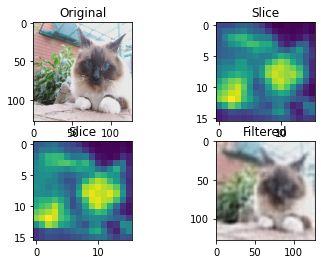

In [12]:
img_broker = mb.ModelBroker(trainset=img_train,
                            testset=img_test,
                            dirname=dataset+"_img",
                            keep_percent=0.1,
                            count=3,
                            sample_size=100)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh,
                            #activation_before=True)
imghead,imginvhead = img_broker.build_model()
imghead,imginvhead = img_broker.load_model()                                      
img_broker.check_build(imghead,imginvhead,img_train)

keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 16.0
saving to: models/pets_seg
out.shape (1, 16, 16, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.

array([[[0.84077579, 0.82043266, 0.85002828],
        [0.75807554, 0.76340646, 0.76702166],
        [0.79583001, 0.79583001, 0.78798687],
        ...,
        [0.18732743, 0.19736113, 0.22285205],
        [0.37809271, 0.49217317, 0.43411916],
        [0.64405996, 0.72917837, 0.66868997]],

       [[0.82052076, 0.78886533, 0.83022559],
        [0.76276493, 0.76386791, 0.78096348],
        [0.72815323, 0.72815323, 0.72546244],
        ...,
        [0.41054496, 0.50570381, 0.44661242],
        [0.187213  , 0.25816149, 0.22587438],
        [0.69288808, 0.82094103, 0.77294326]],

       [[0.7884658 , 0.75813496, 0.78987515],
        [0.7810303 , 0.77799195, 0.7996704 ],
        [0.7547586 , 0.7547586 , 0.7547586 ],
        ...,
        [0.19370285, 0.17014207, 0.17250043],
        [0.40280718, 0.49493387, 0.47501391],
        [0.59110034, 0.67578173, 0.64795977]],

       ...,

       [[0.91644239, 0.94908637, 0.93761277],
        [0.83577758, 0.88079166, 0.86692566],
        [0.47230873, 0

sample.shape (128, 128, 3)
pred.shape (1, 16, 16, 16)
recon.shape (128, 128, 3)
sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  19.49019157221189
ncc =  [[1.         0.96022644]
 [0.96022644 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[-0.00533521  0.00197747 -0.00751374 -0.00830283]
 [ 0.00356981  0.0172665   0.00296824  0.00265268]
 [ 0.00720699  0.01662696  0.01461023  0.00919345]
 [-0.00133319  0.0075699   0.01549511  0.01124774]], shape=(4, 4), dtype=float64)


(19.49019157221189,
 array([[1.        , 0.96022644],
        [0.96022644, 1.        ]]))

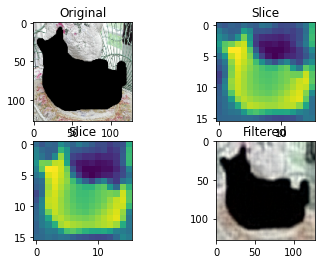

In [13]:
seg_broker = mb.ModelBroker(trainset=seg_train,
                            testset=seg_test,
                            dirname=dataset+"_seg",
                            keep_percent=0.1,
                            count=3,
                            sample_size=100)
                            #activity_regularizer =scaledtanh ,
                            #inverse_activity_regularizer=scaledatanh ,
                            #activation_before=False)
seghead,seginvhead = seg_broker.build_model()                                        
seghead,seginvhead = seg_broker.load_model()
seg_broker.check_build(seghead,seginvhead,seg_test)

# Training

This is the loop used to find the variables to find A and b in y=Ax+b

In [14]:
imgflat = np.prod(imghead(next(iter(img_train))[0]).shape)
segflat = np.prod(seghead(next(iter(seg_train))[0]).shape)
end_shape = next(iter(seg_train))[0].shape
n = 0.0

xxt = np.zeros([imgflat])
yxt = np.zeros([segflat])
x = np.zeros([imgflat])
y = np.zeros([segflat]) 

bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

for item in iter(zip(img_train,seg_train)):

    bar.update(1)

    image = item[0][0]
    segmentation = item[1][0]

    imgdecom = imghead(image)
    segdecom = seghead(segmentation)

    mat = tf.reshape(imgdecom,[-1])
    segmat = tf.reshape(segdecom,[-1])

    cov = tf.matmul([mat],[mat],transpose_a=True)
    xxt += cov
    segcov = tf.matmul([mat],[segmat],transpose_a=True)
    yxt += segcov
    x+=mat
    y+=segmat
    n += 1

print("loop calculated")
xxt = xxt - tf.matmul([x],[x],transpose_a=True)/n
yxt = yxt - tf.matmul([x],[y],transpose_a=True)/n
print("calculating inverse")
inverse_xxt = tf.linalg.pinv(xxt)
print("calculating A")
A = tf.linalg.matmul(inverse_xxt,yxt)
print("calculating b")
b = (y - tf.linalg.matvec(A,x,transpose_a=True))/n

  0%|          | 0/7000 [00:00<?, ?it/s]

loop calculated
calculating inverse
calculating A
calculating b


In [ ]:
threshold_intensity = 0.01
dice_coeff_vals = []
iou_coeff_vals = []
n = 0
reconstruct = seghead(next(iter(seg_ds))[0]).shape
for image,seg_base in iter(zip(img_ds,seg_ds)):
    imgdecom = imghead(image[0])
    imgdecom = tf.reshape(imgdecom,(1,-1))
    segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
    seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
    y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
    y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
    dice_coeff_vals.append(dice_coef(y_true,y_pred))
    iou_coeff_vals.append(iou_coef(y_true,y_pred))
    n+=1

In [ ]:
img_train, img_test = loader.import_processed_img()

In [ ]:
threshold_intensity = 0.1

image,seg_base = next(iter(zip(img_train,seg_train)))
imgdecom = imghead(image[0])

conv = tf.nn.conv2d(imgdecom, A_filter,1,"VALID")
conv = tf.nn.bias_add(conv,b)
seg = seginvhead(conv)

plt.subplot(2,1,1)
plt.imshow(np.hstack([image,seg_base,seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([tf.reduce_min(seg_base,2)==0,tf.reduce_min(seg[0],2)<threshold_intensity]))